<a href="https://colab.research.google.com/github/Makesomenotes/kdd_trading/blob/main/part_2/Model%2Bgradients.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import gdown
from matplotlib import pyplot as plt
import numpy as np 
import pandas as pd
from tqdm.notebook import tqdm

import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F

## Download Data

In [49]:
url = 'https://drive.google.com/uc?id=1UnIk64eM2p32GdsaYIIan-09G0kE7Xmt'
output = 'data.zip'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1UnIk64eM2p32GdsaYIIan-09G0kE7Xmt
To: /content/data.zip
100%|██████████| 3.11G/3.11G [00:45<00:00, 69.1MB/s]


'data.zip'

In [50]:
!unzip data.zip

Archive:  data.zip
replace Fish_Dataset/Black Sea Sprat/Black Sea Sprat/00001.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace Fish_Dataset/Black Sea Sprat/Black Sea Sprat/00002.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace Fish_Dataset/Black Sea Sprat/Black Sea Sprat/00003.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## Prepare Dataset and Dataloader

In [3]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [4]:
data_dir = 'Fish_Dataset'

classes = []

for directory in os.listdir(data_dir):
    if "." not in directory:
        classes.append(directory)
        
print(classes)

['Trout', 'Shrimp', 'Hourse Mackerel', 'Red Sea Bream', 'Gilt-Head Bream', 'Striped Red Mullet', 'Sea Bass', 'Red Mullet', 'Black Sea Sprat']


In [5]:
image_paths = []
image_classes = []
label_to_class = {}
for i, cls in enumerate(classes):
    label_to_class[i] = cls
    objects = os.listdir(os.path.join(data_dir, cls, cls))
    image_classes += len(objects) * [i]
    image_paths.extend(os.path.join(data_dir, cls, cls, i) for i in objects)

data = pd.DataFrame({'path':image_paths, 'class':image_classes})

In [6]:
data.head(3)

,path,class
0,Fish_Dataset/Trout/Trout/00902.png,0
1,Fish_Dataset/Trout/Trout/00191.png,0
2,Fish_Dataset/Trout/Trout/00072.png,0


In [7]:
transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5),std=(0.5, 0.5, 0.5))
    ])

In [8]:
class MarketFishDataset(Dataset):
    def __init__(self, data, root_dir, transform=transforms.ToTensor()):
        self.data = data
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name = self.data.iloc[idx, 0]
        image = Image.open(img_name)
        y_label = torch.tensor(self.data.iloc[idx, 1])
        
        if self.transform:
            image = self.transform(image)
    
        return (image, y_label)

In [9]:
dataset = MarketFishDataset(
    data=data,
    root_dir=data_dir,
    transform=transform
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


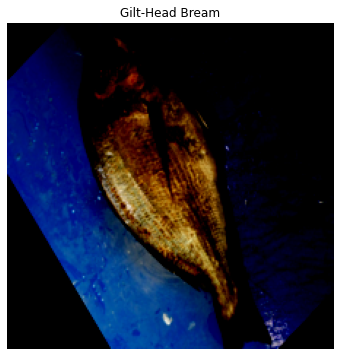

In [10]:
img, lab = dataset[4100]
plt.figure(figsize=(6, 6))
plt.imshow(img.numpy().transpose((1, 2, 0)))
plt.title(label_to_class[int(lab)])
plt.axis('off')
plt.show()

In [11]:
size = len(dataset)
print(f'Dataset size {size}')

Dataset size 9000


In [12]:
batch_size = 32
train_size = int(size * 0.8)
test_size = size - train_size
train_set, test_set = torch.utils.data.random_split(dataset, [train_size, test_size], generator=torch.Generator().manual_seed(42))
train_loader = DataLoader(dataset=train_set,
                          batch_size=batch_size,
                          shuffle=True)
test_loader = DataLoader(dataset=test_set,
                         batch_size=batch_size,
                         shuffle=True)

In [13]:
batch_example = next(iter(train_loader))
print(f'Image batch size: {batch_example[0].shape}')
print(f'Label batch size: {batch_example[1].shape}')

Image batch size: torch.Size([32, 3, 224, 224])
Label batch size: torch.Size([32])


## Creating the Neural Network

In [14]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

In [15]:
def train(model, optimizer, criterion, epochs, train_loader, test_loader):
    loss_train, loss_test = [], []
    accuracy_train, accuracy_test = [], []

    for epoch in range(epochs):
        model.train()
        corrects = 0
        total = 0
        loss_list = []
        for images, labels in tqdm(train_loader):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            predictions = torch.max(outputs, 1)[1].to(DEVICE)

            total += len(labels)
            corrects += (predictions == labels).sum().item()
            loss_list.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        accuracy_train.append(100 * corrects / float(total))
        loss_train.append(np.mean(loss_list))

        model.eval()
        corrects = 0
        total = 0
        loss_list = []
        for images, labels in tqdm(test_loader):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            predict = torch.max(outputs.data, 1)[1].to(DEVICE)

            total += len(labels)
            corrects += (predict == labels).sum().item()
            loss_list.append(loss.item())

        accuracy_test.append(100 * corrects / float(total))
        loss_test.append(np.mean(loss_list))

        print(f"Epoch: {epoch + 1} | Train | Loss: {loss_train[-1]} | Acuracy: {accuracy_train[-1]}")
        print(f"Epoch: {epoch + 1} | Test | Loss: {loss_test[-1]} | Acuracy: {accuracy_test[-1]}\n")
    return accuracy_train, loss_train, accuracy_test, loss_test

### Simple CNN


In [16]:
class CNN(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(CNN, self).__init__()
        self.out_dim = out_dim
        
        self.convs = nn.Sequential(
            nn.Conv2d(in_dim, 8, 8, stride=4, padding=0),
            nn.ReLU(),
            nn.Conv2d(8, 16, 5, stride=2, padding=0),
            nn.ReLU(),
            nn.Conv2d(16, 32, 5, stride=1, padding=0),
            nn.ReLU()
        )
        
        self.linear1 = nn.Linear(22 * 22 * 32, 256)
        self.linear2 = nn.Linear(256, 64)
        self.linear3 = nn.Linear(64, out_dim)
    
    def forward(self, x):
        conv = self.convs(x)
        flattened = conv.reshape(-1, 22 * 22 * 32)
        linear1 = F.relu(self.linear1(flattened))
        linear2 = self.linear2(linear1)
        out = self.linear3(linear2)
        return out

In [17]:
input_dim = dataset[0][0].shape[0] # number of channels (RGB - 3)
output_dim = len(classes) # number of classes
model = CNN(input_dim, output_dim).to(DEVICE)

criterion = nn.CrossEntropyLoss()
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [18]:
# Запускать только при обучении моделей
# epochs = 8
# accuracy_train, loss_train, accuracy_test, loss_test = train(model, optimizer, criterion, epochs, train_loader, test_loader)

In [19]:
# torch.save(model.state_dict(), 'simple_cnn.pth')

In [20]:
# Загрузка весов модели
url = 'https://drive.google.com/uc?id=1ENDvYnc0A4Z3CHwVooqSDdKL9wMmuzC9'
output = 'simple_cnn.pth'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1ENDvYnc0A4Z3CHwVooqSDdKL9wMmuzC9
To: /content/simple_cnn.pth
100%|██████████| 16.0M/16.0M [00:00<00:00, 184MB/s]


'simple_cnn.pth'

In [21]:
model.load_state_dict(torch.load('simple_cnn.pth'))
model.eval()

CNN(
  (convs): Sequential(
    (0): Conv2d(3, 8, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(8, 16, kernel_size=(5, 5), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (5): ReLU()
  )
  (linear1): Linear(in_features=15488, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=9, bias=True)
)

## Find required examples

In [ ]:
def print_examples(feature):
  for i in range(2):
    img, lab = test_set[feature[i]]
    plt.figure(figsize=(6, 6))
    plt.imshow(img.numpy().transpose((1, 2, 0)))
    plt.title(label_to_class[int(lab)])
    plt.axis('off')
    plt.show()

In [22]:
true_label = []
predicted_label = []
probits = []
for sample in tqdm(test_set):
    image, label = sample
    predict = F.softmax(model(image[None, ...].to(DEVICE)), dim=1)
    true_label.append(int(label))
    predicted_label.append(np.argmax(predict.cpu().detach().numpy()))
    probits.append(predict.cpu().cpu().detach().numpy())

  0%|          | 0/1800 [00:00<?, ?it/s]

In [23]:
index = np.arange(1800)
probits_arr = np.vstack(probits)
true_label_arr = np.vstack(true_label)
predicted_label_arr = np.vstack(predicted_label)

In [24]:
np.random.seed(42)

In [116]:
correctly_classified = (true_label_arr == predicted_label_arr).reshape(-1)
correct_prob = probits_arr[correctly_classified]
corr_index = index[correctly_classified]

sorted_prob = np.argsort(correct_prob.max(axis=1))
max_index_corr = corr_index[np.random.choice(sorted_prob[-10:], 2)]
min_index_corr = corr_index[np.random.choice(sorted_prob[:10], 2)]

In [117]:
incorrectly_classified = (true_label_arr != predicted_label_arr).reshape(-1)
incorrect_prob = probits_arr[incorrectly_classified]
incorr_index = index[incorrectly_classified]

sorted_prob = np.argsort(incorrect_prob.max(axis=1))
max_index_incorr = incorr_index[np.random.choice(sorted_prob[-10:], 2)]
min_index_incorr = incorr_index[np.random.choice(sorted_prob[:10], 2)]

In [118]:
# Нужные примеры достаем из test_set
test_set[max_index_corr[0]]

(tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]]), tensor(3))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


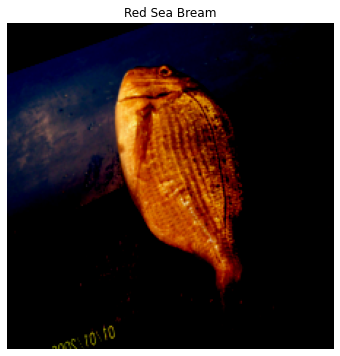

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


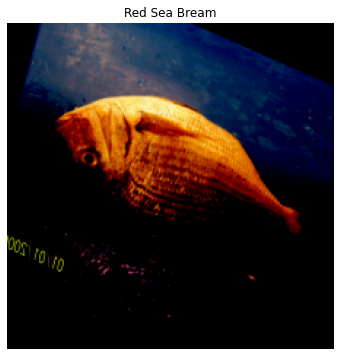

In [119]:
# 2 примера правильно классифицированных с высокой вероятностью принадлежности к классу
print_examples(max_index_corr)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


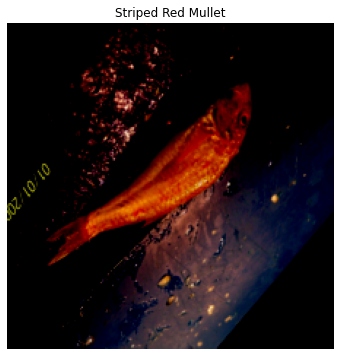

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


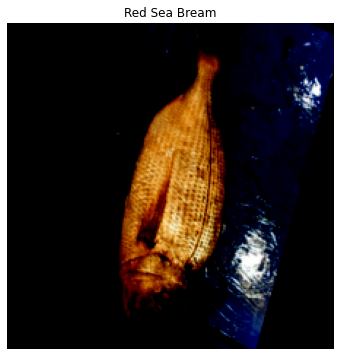

In [120]:
# 2 примера правильно классифицированных с низкой вероятностью принадлежности к классу
print_examples(min_index_corr)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


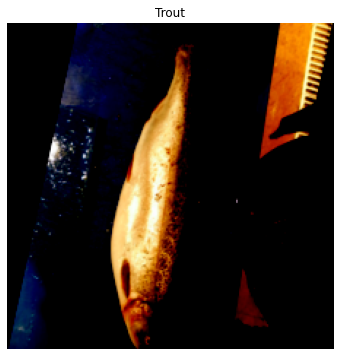

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


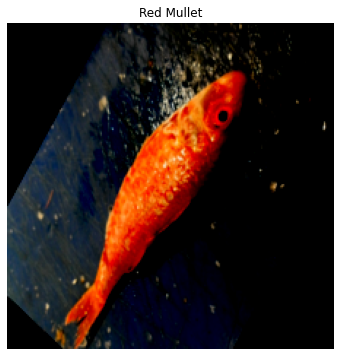

In [121]:
# 2 примера неправильно классифицированных с высокой (с максимально возможной) вероятностью принадлежности к классу
print_examples(max_index_incorr)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


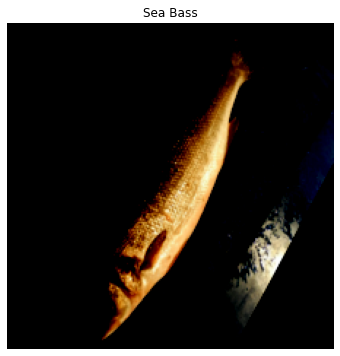

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


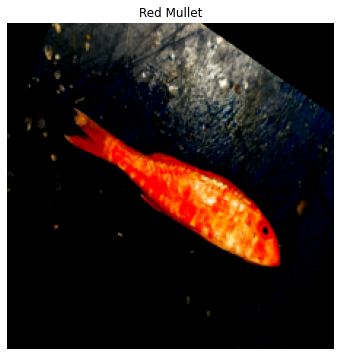

In [122]:
# 2 примера неправильно классифицированных с низкой вероятностью принадлежности к классу
print_examples(min_index_incorr)

## Applying gradients, signals and attribution methods

In [81]:
# !pip install captum

from captum.attr import IntegratedGradients
from matplotlib.colors import LinearSegmentedColormap
from captum.attr import visualization as viz
from captum.attr import NoiseTunnel

In [150]:
# img = Image.open('/content/fish.jpeg')
# transformed_img = transform(img)

def gradients_visualize(feature):
  transformed_img = test_set[feature[0]][0]
  transformed_img = transformed_img.to(DEVICE)

  input = transformed_img
  input = input.unsqueeze(0)

  output = model(input)
  output = F.softmax(output, dim=1)
  prediction_score, pred_label_idx = torch.topk(output, 1)

  pred_label_idx.squeeze_()
  predicted_label = label_to_class[int(pred_label_idx.item())]
  print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')

  # Create IntegratedGradients object and get attributes
  integrated_gradients = IntegratedGradients(model)
  attributions_ig = integrated_gradients.attribute(input, target=pred_label_idx, n_steps=200)

  # create custom colormap for visualizing the result
  default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                  [(0, '#ffffff'),
                                                    (0.25, '#000000'),
                                                    (1, '#000000')], N=256)

  # # visualize the results using the visualize_image_attr helper method
  # _ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
  #                              np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
  #                              methods=["original_image", "heat_map"],
  #                              signs=['all', 'positive'],
  #                              cmap=default_cmap,
  #                              show_colorbar=True)

  noise_tunnel = NoiseTunnel(integrated_gradients)

  attributions_ig_nt = noise_tunnel.attribute(input,  nt_type='smoothgrad_sq', target=pred_label_idx)

  _ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
                              np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                              methods=["original_image", "heat_map"],
                              signs=['all', 'positive'],
                              cmap=default_cmap,
                              show_colorbar=True)

Predicted: Red Sea Bream ( 0.9999762773513794 )


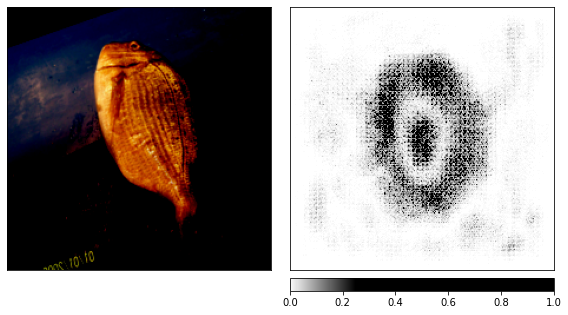

In [151]:
# пример правильной классификации с высокой вероятностью принадлежности к классу
gradients_visualize(max_index_corr)

Predicted: Striped Red Mullet ( 0.5849849581718445 )


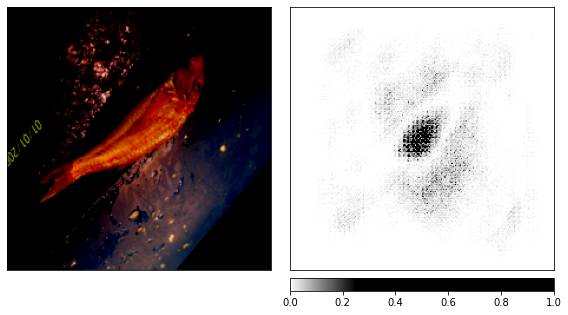

In [152]:
# пример правильной классификации с низкой вероятностью принадлежности к классу
gradients_visualize(min_index_corr)

Predicted: Shrimp ( 0.999994158744812 )


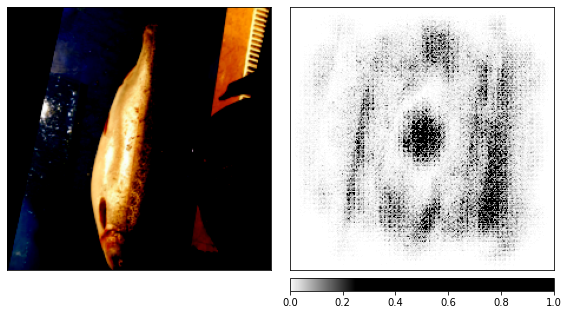

In [153]:
# пример неправильной классификации с высокой (с максимально возможной) вероятностью принадлежности к классу
gradients_visualize(max_index_incorr)

Predicted: Red Mullet ( 0.4778973162174225 )


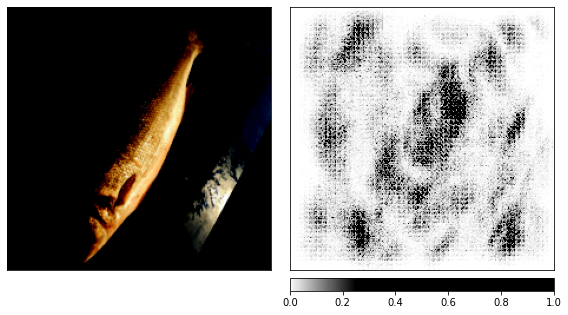

In [154]:
# пример неправильной классификации с низкой вероятностью принадлежности к классу
gradients_visualize(min_index_incorr)